In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
!pip install tensorflow

In [36]:
!pip install visualkeras

In [37]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings("ignore")
import visualkeras

In [38]:
# View random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1) # randomly sample one file in that directory

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [39]:
# Function to plot the loss and accuracy
def plot_model_evaluation(hist):
    hist_keys = [i for i in hist.history.keys()]
    plt.figure()
    plt.plot(hist.history[hist_keys[0]])
    plt.plot(hist.history[hist_keys[2]])
    plt.legend(['train_loss','val_loss'])
    plt.title('Loss')
    plt.show()

    plt.figure()
    plt.plot(hist.history[hist_keys[1]])
    plt.plot(hist.history[hist_keys[3]])
    plt.legend(['train_acc','val_acc'])
    plt.title('Accuracy')
    plt.show()

In [40]:
def get_prediction(model, data):
    label = list(data.class_indices.keys())
    y_true = data.classes
    y_preds = model.predict(data)
    y_pred = np.argmax(y_preds, axis=1)

    return label, y_true, y_pred

In [41]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [42]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a classification model.

  Args:
  -----
  y_true = true labels
  y_pred = predicted labels

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [44]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [45]:
print(os.listdir)

<built-in function listdir>


Image shape: (3468, 4624, 3)


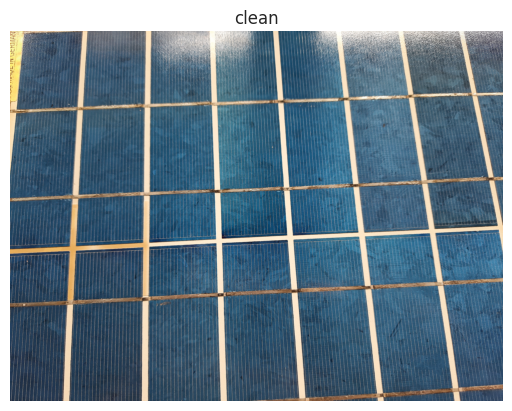

In [46]:
clean_img = view_random_image(target_dir = "/content/drive/MyDrive/dataset/", target_class="clean")

Image shape: (450, 640, 3)


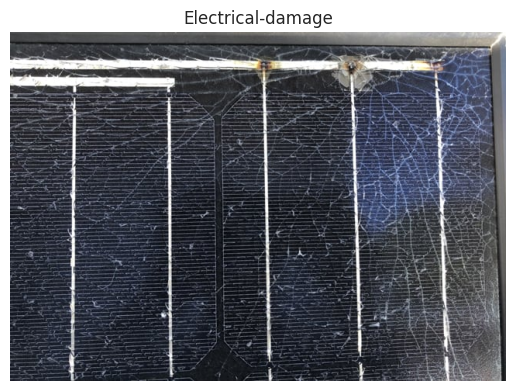

In [47]:
clean_img = view_random_image(target_dir = "/content/drive/MyDrive/dataset/", target_class="Electrical-damage")

In [48]:
data = '/content/drive/MyDrive/dataset'
filepaths = []
labels = []

folds = os.listdir(data)
for fold in folds:
    foldpath = os.path.join(data, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data = pd.concat([Fseries, Lseries], axis= 1)
data

filepaths        labels
0     /content/drive/MyDrive/dataset/dirty/20210916_...         dirty
1     /content/drive/MyDrive/dataset/dirty/20210916_...         dirty
2     /content/drive/MyDrive/dataset/dirty/20210916_...         dirty
3     /content/drive/MyDrive/dataset/dirty/20210916_...         dirty
4     /content/drive/MyDrive/dataset/dirty/20210916_...         dirty
...                                                 ...           ...
1653  /content/drive/MyDrive/dataset/Snow-Covered/Sn...  Snow-Covered
1654  /content/drive/MyDrive/dataset/Snow-Covered/Sn...  Snow-Covered
1655  /content/drive/MyDrive/dataset/Snow-Covered/Sn...  Snow-Covered
1656  /content/drive/MyDrive/dataset/Snow-Covered/Sn...  Snow-Covered
1657  /content/drive/MyDrive/dataset/Snow-Covered/Sn...  Snow-Covered

[1658 rows x 2 columns]

In [49]:
# Train test split the data
train_df, dummy_df = train_test_split(data,
                                      train_size= 0.8,
                                      shuffle= True,
                                      random_state= 42)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,
                                     train_size= 0.6,
                                     shuffle= True,
                                     random_state= 42)

len(train_df), len(valid_df), len(test_df)

(1326, 199, 133)

In [50]:
# ImageDataGenerator (turning into DataLoaders)
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

img_datagen = ImageDataGenerator()
train_data = img_datagen.flow_from_dataframe(train_df,
                                            x_col= 'filepaths',
                                            y_col= 'labels',
                                            target_size= IMG_SIZE,
                                            class_mode= 'categorical',
                                            color_mode= 'rgb',
                                            shuffle= True,
                                            batch_size= BATCH_SIZE)

valid_data = img_datagen.flow_from_dataframe(valid_df,
                                            x_col= 'filepaths',
                                            y_col= 'labels',
                                            target_size= IMG_SIZE,
                                            class_mode= 'categorical',
                                            color_mode= 'rgb',
                                            shuffle= False,
                                            batch_size= BATCH_SIZE)

test_data = img_datagen.flow_from_dataframe(test_df,
                                           x_col= 'filepaths',
                                           y_col= 'labels',
                                           target_size= IMG_SIZE,
                                           class_mode= 'categorical',
                                           color_mode= 'rgb',
                                           shuffle= False,
                                           batch_size= BATCH_SIZE)

Found 1326 validated image filenames belonging to 5 classes.
Found 199 validated image filenames belonging to 5 classes.
Found 133 validated image filenames belonging to 5 classes.


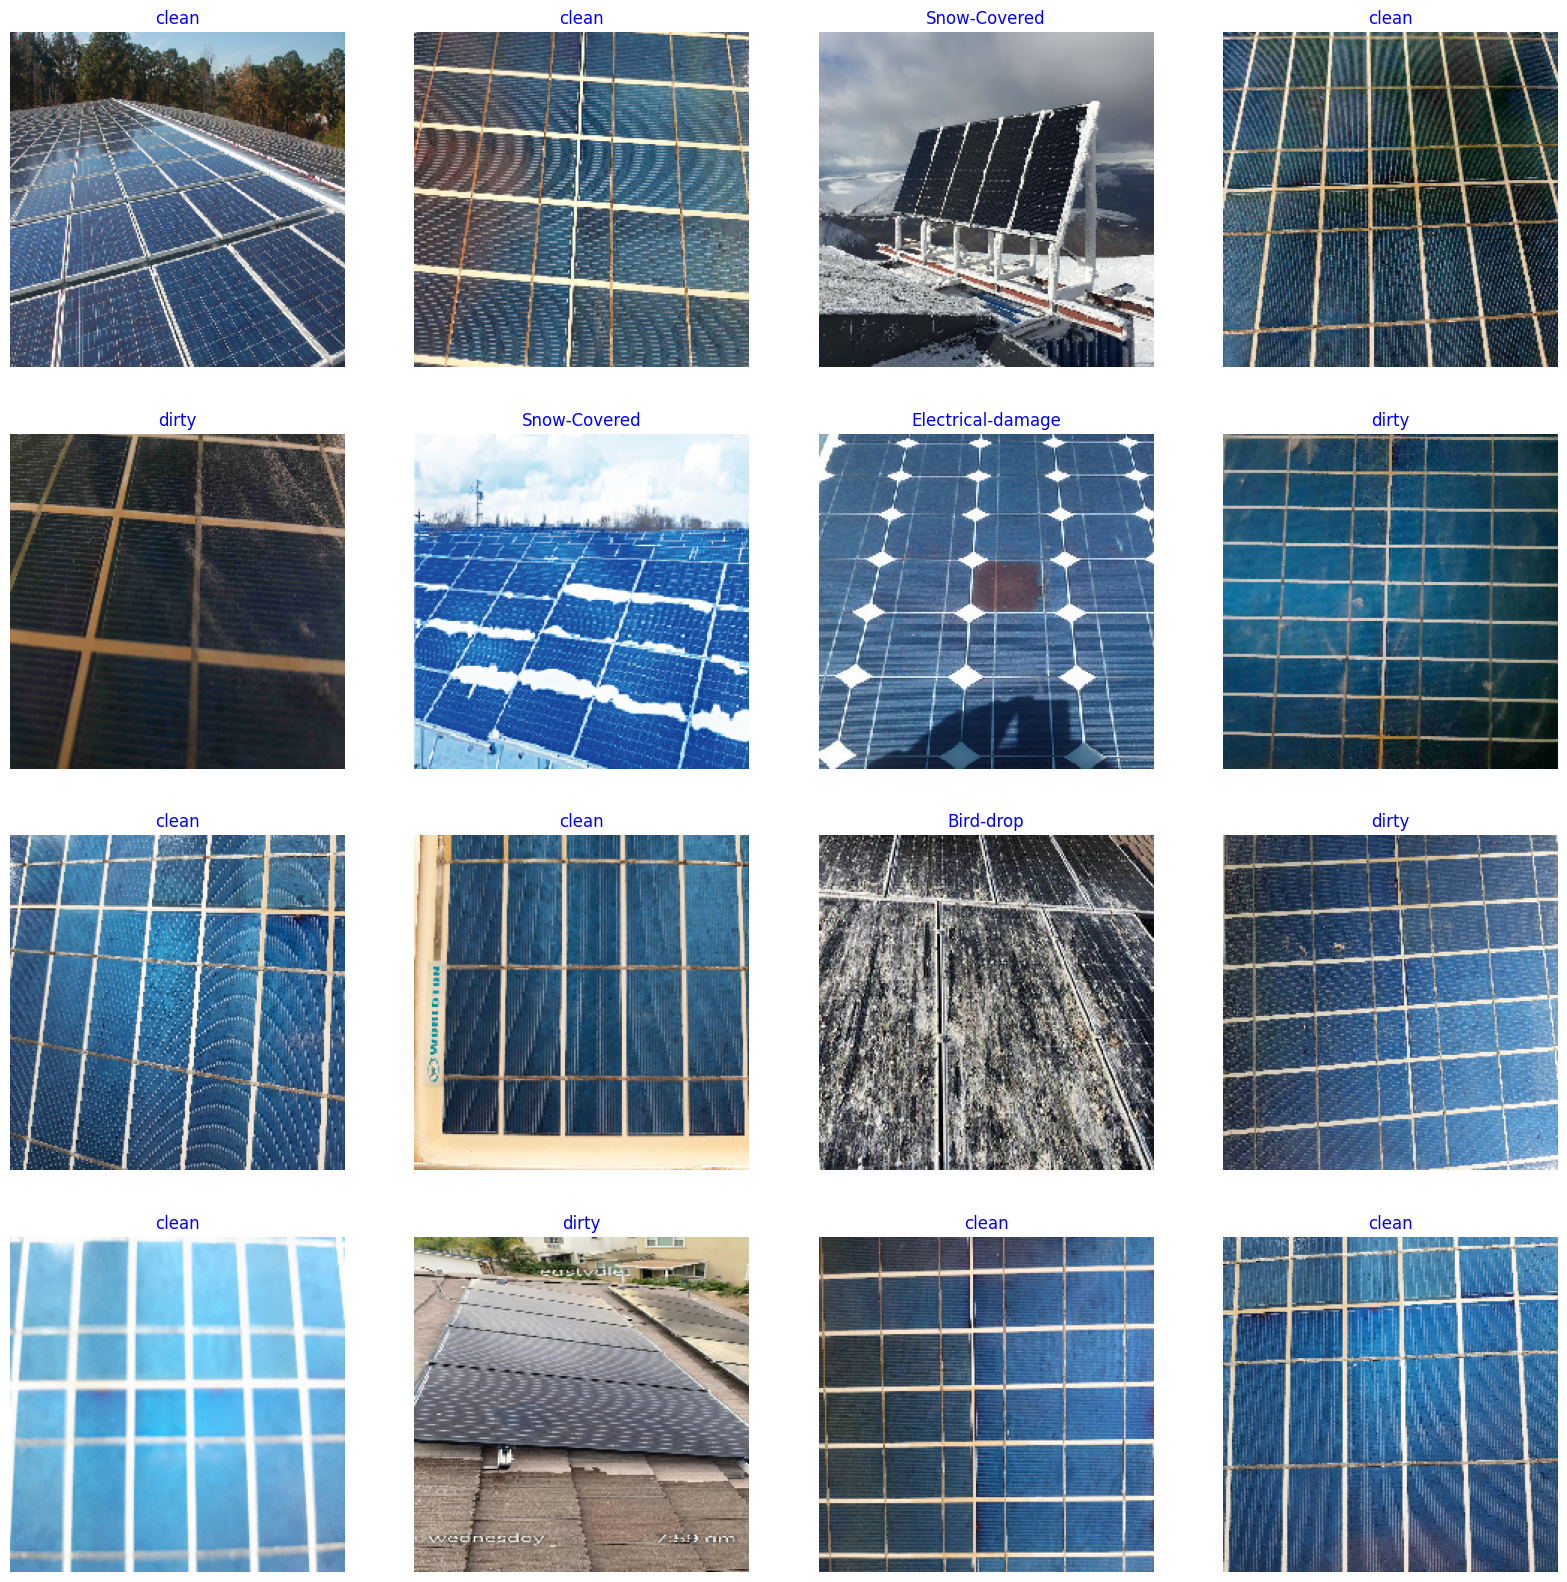

In [51]:
# Visualization
g_dict = train_data.class_indices
classes = list(g_dict.keys())
images, labels = next(train_data)

plt.figure(figsize= (20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [52]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
N_CLASSES = len(list(train_data.class_indices.keys()))

import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0

# base model
efficientnet_model = EfficientNetB0(include_top= False,
                                    weights= "imagenet",
                                    input_shape= IMG_SHAPE,
                                    pooling= 'max')
efficientnet_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMG_SHAPE, name="Input_layer")
x = efficientnet_model(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, kernel_regularizer= regularizers.l2(l= 0.02),
          activity_regularizer= regularizers.l1(0.01),
          bias_regularizer= regularizers.l1(0.01),
          activation= 'relu')(x)
x = Dropout(rate= 0.5, seed= 123)(x)
outputs = tf.keras.layers.Dense(N_CLASSES, activation= 'sigmoid')(x)
efficientnet_tl = tf.keras.Model(inputs=inputs, outputs=outputs)
efficientnet_tl.compile(Adam(learning_rate= 0.001),
              loss= 'binary_crossentropy',
              metrics= ['accuracy'])

efficientnet_tl.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_2 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 1285

In [53]:
batch_size = 10   # set batch size for training
EPOCHS =  10  # number of all epochs in training

efficientnet_tl_history = efficientnet_tl.fit(
    x= train_data,
    epochs= EPOCHS,
    steps_per_epoch=len(train_data),
    verbose= 1,
    validation_data= valid_data,
    validation_steps= len(valid_data))

Epoch 1/10
42/42 [==============================] - 246s 6s/step - loss: 6.9669 - accuracy: 0.6192 - val_loss: 4.0478 - val_accuracy: 0.7789
Epoch 2/10
42/42 [==============================] - 221s 5s/step - loss: 2.4667 - accuracy: 0.8160 - val_loss: 1.4276 - val_accuracy: 0.8543
Epoch 3/10
42/42 [==============================] - 227s 5s/step - loss: 0.9993 - accuracy: 0.8386 - val_loss: 0.7213 - val_accuracy: 0.8492
Epoch 4/10
42/42 [==============================] - 230s 5s/step - loss: 0.6179 - accuracy: 0.8522 - val_loss: 0.5449 - val_accuracy: 0.8291
Epoch 5/10
42/42 [==============================] - 232s 6s/step - loss: 0.5194 - accuracy: 0.8552 - val_loss: 0.5103 - val_accuracy: 0.7688
Epoch 6/10
42/42 [==============================] - 239s 6s/step - loss: 0.4784 - accuracy: 0.8605 - val_loss: 0.4706 - val_accuracy: 0.8191
Epoch 7/10
42/42 [==============================] - 230s 5s/step - loss: 0.4557 - accuracy: 0.8567 - val_loss: 0.4409 - val_accuracy: 0.8894
Epoch 8/10
42

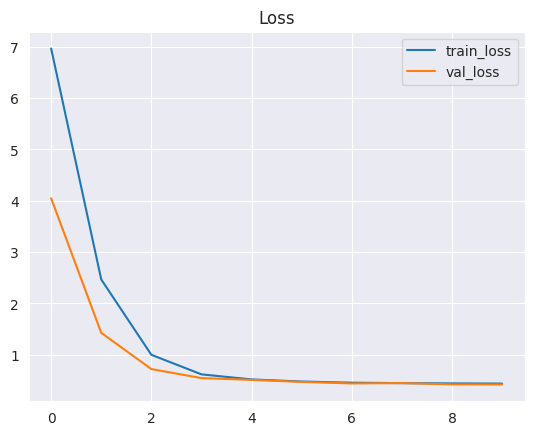

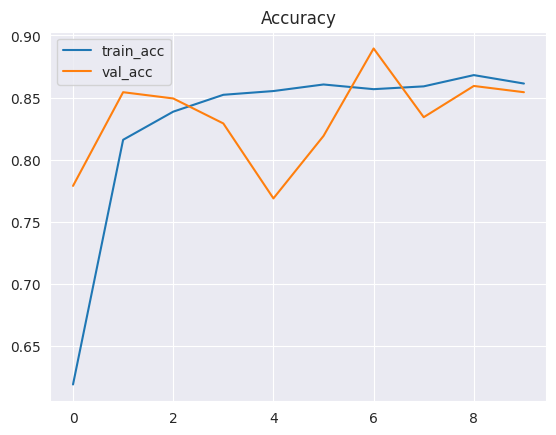

In [54]:
plot_model_evaluation(efficientnet_tl_history)

5/5 [==============================] - 23s 4s/step


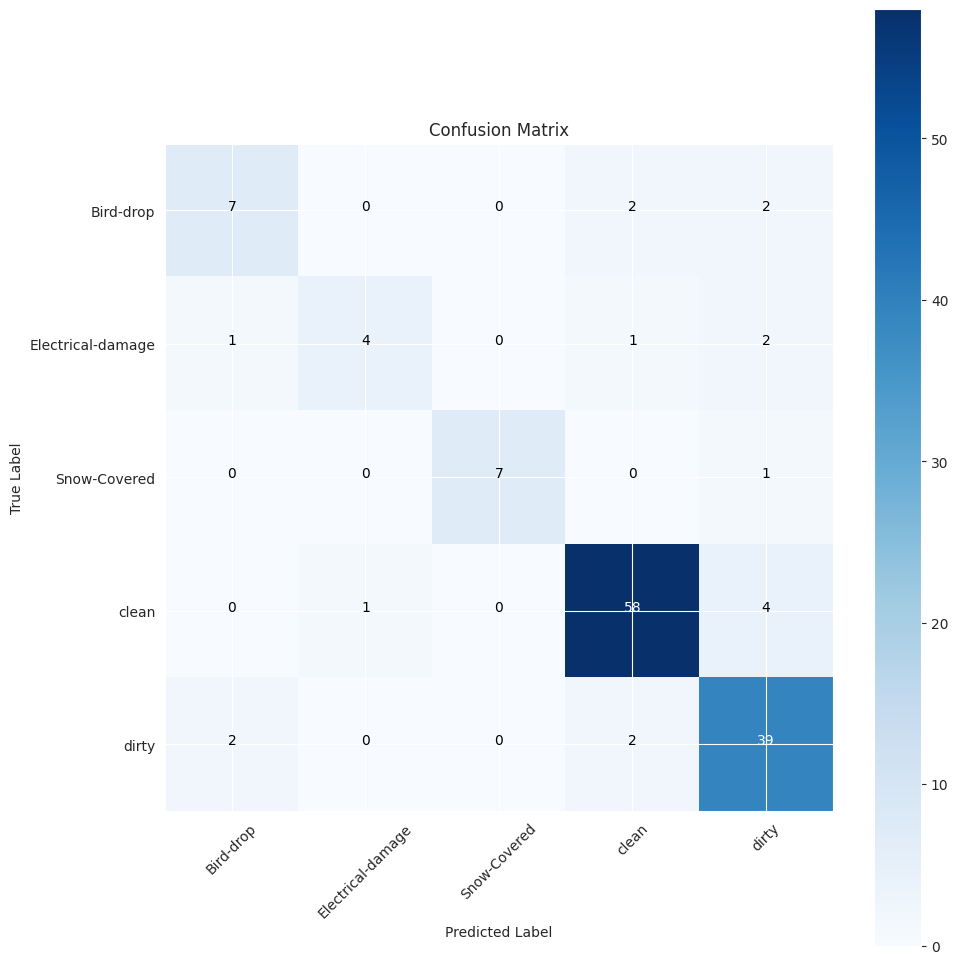

None
                   precision    recall  f1-score   support

        Bird-drop       0.70      0.64      0.67        11
Electrical-damage       0.80      0.50      0.62         8
     Snow-Covered       1.00      0.88      0.93         8
            clean       0.92      0.92      0.92        63
            dirty       0.81      0.91      0.86        43

         accuracy                           0.86       133
        macro avg       0.85      0.77      0.80       133
     weighted avg       0.86      0.86      0.86       133



In [55]:
# Get predictions
classes, efficientnet_tl_y_true, efficientnet_tl_y_pred = get_prediction(efficientnet_tl, test_data)
# Confusion matrix
print(plot_confusion_matrix(efficientnet_tl_y_true, efficientnet_tl_y_pred, classes))

print(classification_report(efficientnet_tl_y_true, efficientnet_tl_y_pred, target_names= classes))

In [57]:
# Get results to save for later
efficientnet_tl_results = calculate_results(y_true=efficientnet_tl_y_true,
                                            y_pred=efficientnet_tl_y_pred)
efficientnet_tl_results

{'accuracy': 86.46616541353383,
 'precision': 0.8649436090225564,
 'recall': 0.8646616541353384,
 'f1': 0.8615054118813518}

In [58]:
#Save the model
efficientnet_tl.save('efficientnet_tl_solar_dust.h5')

In [59]:
efficientnet_tl.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_2 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 1285

In [60]:
# Make all the layers in efficientnet_model trainable
efficientnet_model.trainable = True

efficientnet_base_model = efficientnet_tl.layers[1]
efficientnet_base_model.trainable = True
for layer in efficientnet_base_model.layers[:-10]:
  layer.trainable = False

efficientnet_tl.compile(Adam(learning_rate= 0.0001),
              loss= 'binary_crossentropy',
              metrics= ['accuracy'])

efficientnet_tl.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_2 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 1285

In [61]:
tf.random.set_seed(42)

efficientnet_tl_ft_history = efficientnet_tl.fit(
    train_data,
    epochs=EPOCHS+10,
    initial_epoch=efficientnet_tl_history.epoch[-1],
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
)

Epoch 10/20
42/42 [==============================] - 266s 6s/step - loss: 0.4028 - accuracy: 0.8801 - val_loss: 0.3897 - val_accuracy: 0.8496
Epoch 11/20
42/42 [==============================] - 210s 5s/step - loss: 0.3625 - accuracy: 0.9216 - val_loss: 0.3731 - val_accuracy: 0.8496
Epoch 12/20
42/42 [==============================] - 235s 6s/step - loss: 0.3394 - accuracy: 0.9344 - val_loss: 0.3585 - val_accuracy: 0.8647
Epoch 13/20
42/42 [==============================] - 221s 5s/step - loss: 0.3230 - accuracy: 0.9525 - val_loss: 0.3474 - val_accuracy: 0.8722
Epoch 14/20
42/42 [==============================] - 226s 5s/step - loss: 0.3156 - accuracy: 0.9525 - val_loss: 0.3365 - val_accuracy: 0.8797
Epoch 15/20
42/42 [==============================] - 238s 6s/step - loss: 0.3035 - accuracy: 0.9510 - val_loss: 0.3297 - val_accuracy: 0.8797
Epoch 16/20
42/42 [==============================] - 215s 5s/step - loss: 0.2904 - accuracy: 0.9668 - val_loss: 0.3200 - val_accuracy: 0.8722
Epoch 

10
21
[0.6191553473472595, 0.8159879446029663, 0.8386123776435852, 0.8521870374679565, 0.8552036285400391, 0.8604826331138611, 0.8567119240760803, 0.8589743375778198, 0.8680241107940674, 0.8612368106842041, 0.8800904750823975, 0.9215686321258545, 0.9343891143798828, 0.9524886608123779, 0.9524886608123779, 0.9509803652763367, 0.9668174982070923, 0.9698340892791748, 0.9781296849250793, 0.9758672714233398, 0.9811462759971619]


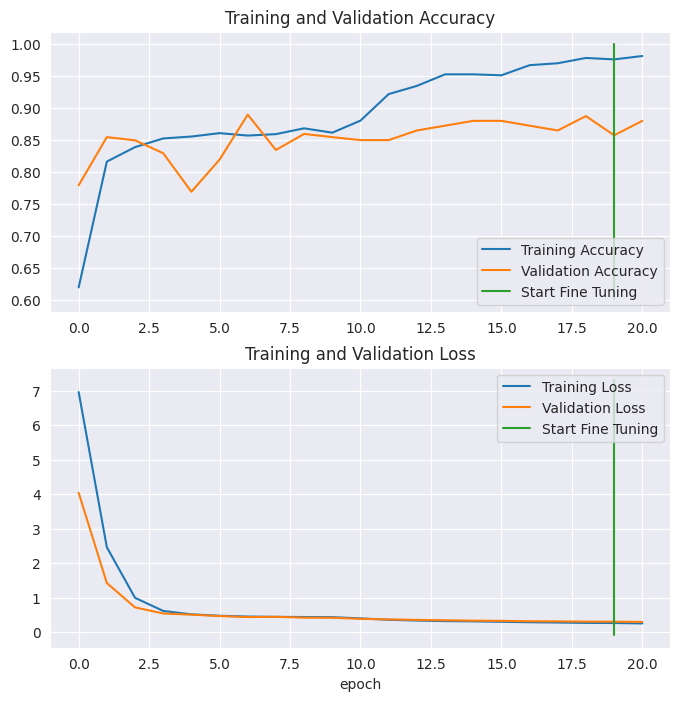

In [62]:
compare_historys(original_history=efficientnet_tl_history,
                 new_history=efficientnet_tl_ft_history,
                 initial_epochs=20)

In [63]:
# Evaluate the fine tuned model
test_len = len(test_df)
test_batch_size = max(sorted([test_len // n for n in range(1, test_len + 1) if test_len%n == 0 and test_len/n <= 80]))
test_steps = test_len // test_batch_size

efficientnet_tl_ft_train_score = efficientnet_tl.evaluate(train_data,
                                                             steps= test_steps,
                                                             verbose= 1)
efficientnet_tl_ft_valid_score = efficientnet_tl.evaluate(valid_data,
                                                             steps= test_steps,
                                                             verbose= 1)
efficientnet_tl_ft_test_score = efficientnet_tl.evaluate(test_data,
                                                            steps= test_steps,
                                                            verbose= 1)

print("Train Loss: ", efficientnet_tl_ft_train_score[0])
print("Train Accuracy: ", efficientnet_tl_ft_train_score[1])
print('-' * 20)
print("Validation Loss: ", efficientnet_tl_ft_valid_score[0])
print("Validation Accuracy: ", efficientnet_tl_ft_valid_score[1])
print('-' * 20)
print("Test Loss: ", efficientnet_tl_ft_test_score[0])
print("Test Accuracy: ", efficientnet_tl_ft_test_score[1])

5/7 [====================>.........] - ETA: 6s - loss: 0.2996 - accuracy: 0.8797 

7/7 [==============================] - 19s 2s/step - loss: 0.2996 - accuracy: 0.8797
Train Loss:  0.22243671119213104
Train Accuracy:  0.9955357313156128
--------------------
Validation Loss:  0.2905266582965851
Validation Accuracy:  0.9195979833602905
--------------------
Test Loss:  0.2996194660663605
Test Accuracy:  0.8796992301940918


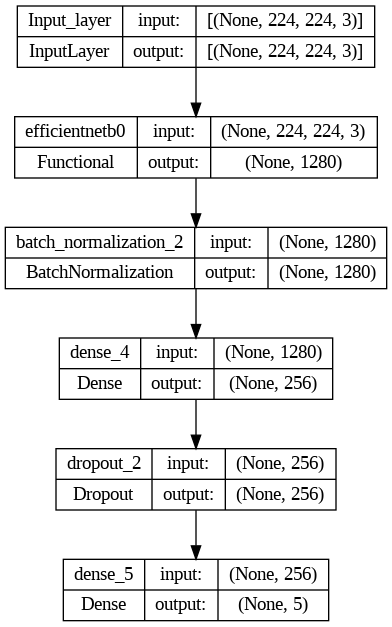

In [64]:
plot_model(efficientnet_tl,show_layer_names=(True),show_shapes=(True))

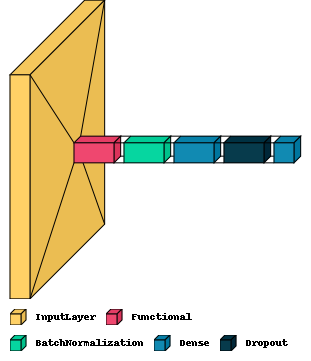

In [65]:
visualkeras.layered_view(efficientnet_tl, legend=True, scale_xy=1, scale_z=2, max_z=40)